# Network Analysis

This notebook performs network analysis across the entire episode.

In [7]:
# Import stuff
from pandas import DataFrame, read_csv
from nipype.pipeline.engine import Workflow, Node, MapNode, JoinNode
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from nipype.interfaces.fsl import GLM, Split, Merge, Cluster
from nipype.interfaces.fsl.maths import MathsCommand

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# Set study variables
analysis_home = '/data/perlman/moochie/user_data/CamachoCat/ChEC/fmri_proc'
templates_dir = '/data/perlman/moochie/user_data/CamachoCat/Aggregate_anats/templates'
preproc_dir = analysis_home + '/proc/preproc'
output_dir = analysis_home + '/proc/network_analysis'
workflow_dir = analysis_home + '/workflows'
affect_ratings = analysis_home + '/misc/ratings_20200427.csv'

gm_mask = templates_dir + '/lcbd_template_2mm_gm.nii.gz'

subject_info = read_csv(analysis_home + '/misc/subjectinfo.csv', index_col=None)
subject_info = subject_info[subject_info['usable.25']==1]
subjects_list = subject_info['SubjID'].tolist()

# data collection specs
TR = 0.8 #in seconds
duration= 1284 # in seconds
wind_dur=45 #in seconds
wind_offset=15 #in seconds
nan_val = 99999

template_atlas = analysis_home + '/template/MMP_subcort_warped.nii.gz'
template_atlas_key = analysis_home + '/template/MMP_subcort.csv'

In [2]:
# Select subjects list
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name='infosource')
infosource.iterables = [('subject_id', subjects_list)]

# Pull files
file_template = {'trim_func': preproc_dir + '/fully_processedtrim/{subject_id}/lomo_trim_func.nii.gz',
                 'nan_func': preproc_dir + '/fully_processednan/{subject_id}/lomo_nan_func.nii.gz'}
selectfiles = Node(SelectFiles(file_template), name='selectfiles')

# Sink data of interest 
substitutions = [('_subject_id_', ''),
                 ('_wind_dur_',''),
                 ('wind_offset_',''),
                 ('_covariates_..data..perlman..moochie..user_data..CamachoCat..ChEC..fmri_proc..misc..group_covariates_','')] #output file name substitutions
datasink = Node(DataSink(base_directory = output_dir,
                        container = output_dir,
                        substitutions = substitutions), 
                name='datasink')

### Make functional parcellation based on sample

In [ ]:
# Select data

# create mean timeseries



### Create overall connectivity matrices

In [ ]:
def correlation_matrix(func,atlas,atlas_labels):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from nilearn.input_data import NiftiLabelsMasker
    from nilearn.connectome import ConnectivityMeasure
    from nilearn import plotting
    import numpy as np
    from pandas import read_csv, DataFrame
    import matplotlib.pyplot as plt

    labels_df = read_csv(atlas_labels, index_col=None)
    labels = labels_df['region_name'].to_list()
    masker = NiftiLabelsMasker(labels_img=atlas, standardize=True)
    time_series = masker.fit_transform(func)

    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    correlation_matrix[correlation_matrix==1]=0
    conn_z = 0.5*np.log((1+correlation_matrix)/(1-correlation_matrix))
    corr_mat_df = DataFrame(correlation_matrix,columns=labels,index=labels)
    corr_mat_df.to_csv('correlation_matrix.csv')

    plt.figure()
    plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                         vmax=0.8, vmin=-0.8, reorder=True)
    plt.savefig('corr_matrix.svg')
    plt.close()
    
    corr_mat_fig = abspath('corr_matrix.svg')
    corr_matrix = abspath('correlation_matrix.csv')
    
    return(corr_matrix, corr_mat_fig)

In [ ]:
## File handling Nodes
calc_connectivity = Node(Function(input_names=['func','atlas','atlas_labels'], 
                                  output_names=['corr_matrix','corr_mat_fig'], 
                                  function=correlation_matrix), 
                         name='calc_connectivity')
calc_connectivity.inputs.atlas = template_atlas
calc_connectivity.inputs.atlas_labels = template_atlas_key

In [ ]:
connect_flow = Workflow(name='connect_flow')
connect_flow.connect([(infosource,selectfiles, [('subject_id','subject_id')]),
                      (selectfiles, calc_connectivity, [('trim_func','func')]),
                      
                      (calc_connectivity, datasink, [('corr_matrix','correlation_matrix'),
                                                     ('corr_mat_fig','corr_matrix_plot')])
                     ])

connect_flow.base_dir = workflow_dir
#connect_flow.write_graph(graph2use='flat')
connect_flow.run('MultiProc', plugin_args={'n_procs': 4, 'memory_gb':30})

In [ ]:
from nilearn import plotting
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt
import numpy as np

labels_df = read_csv(template_atlas_key, index_col=None)

group_conn_data = read_csv(output_dir + '/correlation_matrix/{0}/correlation_matrix.csv'.format(subjects_list[0]), index_col=0)
group_conn_mat = group_conn_data.to_numpy()
group_conn_mat = np.expand_dims(group_conn_mat, axis=2)

for sub in subjects_list[1:]:
    temp = read_csv(output_dir + '/correlation_matrix/{0}/correlation_matrix.csv'.format(sub), index_col=0)
    temp_mat = np.expand_dims(temp.to_numpy(),axis=2)
    group_conn_mat = np.concatenate((group_conn_mat,temp_mat),axis=2)
    
mean_conn_data = np.average(group_conn_mat,axis=2)
mean_conn_df = DataFrame(mean_conn_data, columns=labels_df['region_name'].tolist(), index=labels_df['region_name'].tolist())
labels_df = labels_df.sort_values(by=['network_num'])
mean_conn_df = mean_conn_df.reindex(labels_df['region_name'].tolist(), columns=labels_df['region_name'].to_list())
mean_conn_df.to_csv('group_mean_z.csv')

plt.figure()
plotting.plot_matrix(mean_conn_df.to_numpy(), figure=(6, 6), labels=mean_conn_df.columns.to_list(), reorder=True,
                     vmax=0.8, vmin=-0.8)
plt.savefig(output_dir+'/group_mean_corr_z_matrix.png')
plt.show()
plt.close()

In [ ]:
import bct
import pandas as pd

labels_df = read_csv(template_atlas_key, index_col=None)
labels_df = labels_df.sort_values(by=['network_num'])
col_labels = ['N{0}_cc'.format(x) for x in range(0,8)] + ['N{0}_corr'.format(x) for x in range(0,8)]
coeff_data = pd.DataFrame(columns=col_labels)
final_comms = labels_df.loc[:,['network_num','region_name']]

for sub in subjects_list:
    idx = pd.IndexSlice
    temp = read_csv(output_dir + '/correlation_matrix/{0}/correlation_matrix.csv'.format(sub), index_col=0)
    temp = temp.reindex(labels_df['region_name'].tolist(),columns=labels_df['region_name'].tolist())
    temp.columns = pd.MultiIndex.from_frame(final_comms, names=['network','region'])
    temp.index = pd.MultiIndex.from_frame(final_comms, names=['network','region'])
    for n in range(0,8):
        net = temp.loc[idx[n,n]]
        coeff_data.loc[sub,'N{0}_cc'.format(n)] = bct.clustering_coef_wu(net).mean()
        net[net==1]=np.nan
        coeff_data.loc[sub,'N{0}_corr'.format(n)] = np.nanmean(net.to_numpy())
coeff_data.to_csv('ahkj_conn_cc_data.csv')

In [8]:
import pandas as pd
covariates='/data/perlman/moochie/user_data/CamachoCat/ChEC/fmri_proc/misc/group_covariates_full.csv'
model_data = pd.read_csv(covariates,index_col=0)
model_data.columns

Index(['intercept', 'age_cent', 'male', 'SUR', 'NEG', 'EC', 'censoredFD',
       'cbcl_extern', 'cbcl_intern', 'aim_pos_int', 'aim_neg_int',
       'aim_pos_react', 'aim_neg_react', 'AIM_AIR_neg_intensity',
       'AIM_AIR_neg_reactivity', 'AIM_AIR_pos_affectivity'],
      dtype='object')

In [11]:
from glob import glob
subject_beta_mats=glob(output_dir +'/correlation_matrix/*/correlation_matrix.csv')

import numpy as np
import statsmodels.api as sm
from scipy import stats
import pandas as pd
labels_df = read_csv(template_atlas_key, index_col=None)
labels_df = labels_df.sort_values(by=['network_num'])
final_comms = labels_df.loc[:,['network_num','region_name']]

subject_beta_mats = sorted(subject_beta_mats)

sub_mats = []
for sub in subject_beta_mats:
    t = pd.read_csv(sub, index_col=0)
    t = t.reindex(labels_df['region_name'].tolist(),columns=labels_df['region_name'].tolist())
    t.columns = pd.MultiIndex.from_frame(final_comms, names=['network','region'])
    t.index = pd.MultiIndex.from_frame(final_comms, names=['network','region'])
    t[t==1]= np.nan
    t = t.groupby(level=0).mean()
    t = t.groupby(level=0, axis=1).mean()
    t = t.drop(labels=[0], axis=0)
    t = t.drop(labels=[0], axis=1)
    t = t.to_numpy()
    t = np.expand_dims(t,axis=2)
    sub_mats.append(t)
sub_data = np.concatenate(sub_mats,axis=2)

X = model_data[['intercept','age_cent','male','censoredFD']].to_numpy()

tstats = np.zeros((sub_data.shape[0],sub_data.shape[0],4))
pvals = np.zeros((sub_data.shape[0],sub_data.shape[0],4))

for a in range(0,sub_data.shape[0]):
    for b in range(0,sub_data.shape[0]):
        Y=sub_data[a,b,:]
        model = sm.OLS(Y,X)
        res = model.fit()
        tstats[a,b,:] = res.tvalues
        pvals[a,b,:] = res.pvalues
        
np.save(output_dir + '/full_conn_net_plots/tstats_networks.npy',tstats)
np.save(output_dir + '/full_conn_net_plots/pvals_networks.npy',pvals)

['visual', 'somatomotor', 'dors_att', 'vent_att', 'limbic', 'frontopar', 'default']


/data/perlman/moochie/resources/mri_scripts/mri_proc_env/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:107: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(mat, method=reorder)
/data/perlman/moochie/resources/mri_scripts/mri_proc_env/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:108: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  ordered_linkage = optimal_leaf_ordering(linkage_matrix, mat)


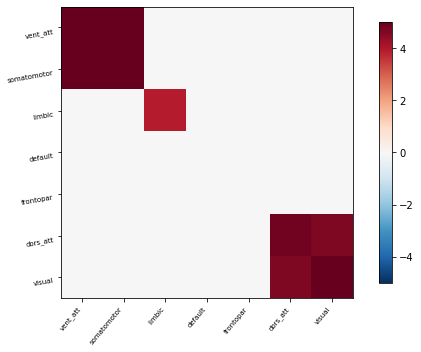

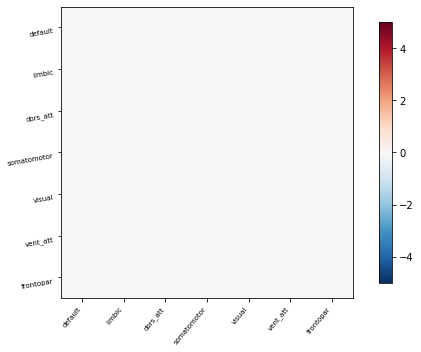

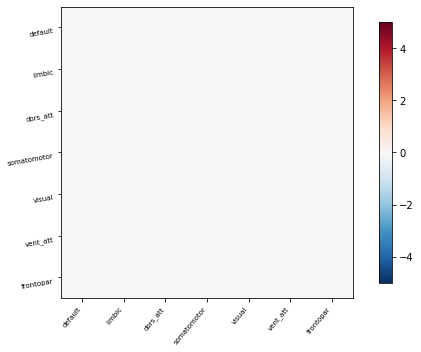

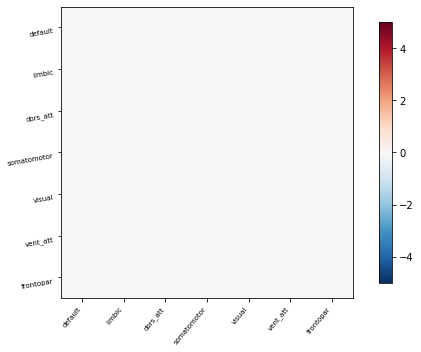

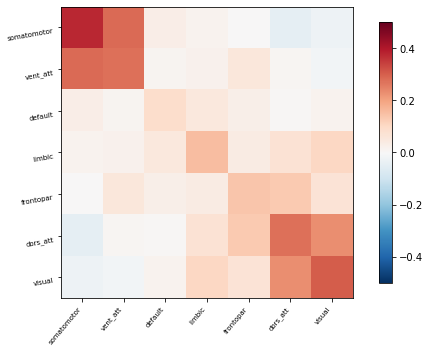

In [17]:
from nilearn import plotting
from chord import Chord
import matplotlib.pyplot as plt
tstats = np.load(output_dir + '/full_conn_net_plots/tstats_networks.npy')
labels_df = read_csv(template_atlas_key, index_col=None)
labels = ['visual','somatomotor','dors_att','vent_att','limbic','frontopar','default']
print(labels)
tstats[pvals>(0.005)]=0

for num in range(0,4):
    mat=tstats[:,:,num]

    plotting.plot_matrix(mat, figure=(6, 6), labels=labels, reorder=True,
                         vmax=5, vmin=-5)
    plt.savefig(output_dir + '/full_conn_net_plots/conn_{0}.svg'.format(num))
    
mean_conn = np.mean(sub_data, axis=2)
plotting.plot_matrix(mean_conn, figure=(6, 6), labels=labels, reorder=True,
                     vmax=0.5, vmin=-0.5)
plt.savefig(output_dir + '/full_conn_net_plots/mean_conn.svg'.format(num))

### Create dynamic connectivity timeseries

In [ ]:
def sliding_connect(func,rate,wind_dur,wind_offset,TR,atlas,nan_val):
    '''This function takes a BOLD timeseries and a ratings series of the same length and 
    uses a sliding window approach to create a new connectivity timeseries.  Windows with
    too many NaNs (1/2 window duration or more) are dropped from the connectivity timeseries and 
    the ratings timeseries.
    
    Inputs:
        func:  the subject's nifti timeseries data.
        rate:  the ratings timeseries (sampled at 1 per TR)
        wind_dur:  width or duration fo sliding window in seconds
        wind_offset:  the gap (in seconds) between the start times of adjacent windows
        TR:  repetition time of the fMRI sequence
        atlas:  parcellation scheme to use for unmasking the fMRI data
        nan_val:  the value used to encode NaN'ed volumes (e.g., due to high motion)
        
    Outputs:
        connect_ts:  dynamic connectivity timeseries
        rate_ts:  newly sampled ratings timeseries
    '''
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from nilearn.input_data import NiftiLabelsMasker
    from nilearn.connectome import ConnectivityMeasure
    import numpy as np
    from pandas import read_csv, DataFrame
    
    masker = NiftiLabelsMasker(labels_img=atlas, standardize=True)
    func_ts = masker.fit_transform(func)
    func_ts[func_ts==nan_val]=np.nan
    rate_ts = read_csv(rate, index_col=0)
    ratings = rate_ts.to_numpy()

    duration = len(func_ts)
    wind_dur_tr = int(wind_dur/TR)
    wind_overlap = int(wind_offset/TR)
    min_wind_dur = int(wind_dur*0.67)

    start = 0
    dyn_conn_mats = []
    dyn_conn_rate = DataFrame(columns=rate_ts.columns)
    corr_meas = ConnectivityMeasure(kind='correlation')
    
    while start+wind_dur_tr < duration:
        end = start + wind_dur_tr
        temp_ts = func_ts[start:end,:]
        temp_rate = ratings[start:end,:]
        tmask = np.isfinite(temp_ts[:,0])
        temp_rate = temp_rate[tmask]
        temp_ts = temp_ts[tmask]
        if temp_ts.shape[0]>=min_wind_dur:
            corr_mat = corr_meas.fit_transform([temp_ts])[0]
            t = np.expand_dims(corr_mat, axis=2)
            dyn_conn_mats.append(t)
            temp_rate = np.mean(temp_rate,axis=0)
            dyn_conn_rate.loc[start,:] = temp_rate
        start += wind_offset

    dyn_conn = np.concatenate(dyn_conn_mats, axis=2)
    np.savez_compressed('dyn_conn_{0}.npz'.format(wind_dur),dyn_conn=dyn_conn)
    dyn_conn_rate.to_csv('dyn_rate_{0}.csv'.format(wind_dur))
    connect_ts = abspath('dyn_conn_{0}.npz'.format(wind_dur))
    rate_ts = abspath('dyn_rate_{0}.csv'.format(wind_dur))
    return(connect_ts, rate_ts)
    
def sliding_network_connect(func,rate,wind_dur,wind_offset,TR,atlas,net_labels,nan_val):
    '''This function takes a BOLD timeseries and a ratings series of the same length and 
    uses a sliding window approach to create a new connectivity timeseries.  Windows with
    too many NaNs (1/2 window duration or more) are dropped from the connectivity timeseries and 
    the ratings timeseries.
    
    Inputs:
        func:  the subject's nifti timeseries data.
        rate:  the ratings timeseries (sampled at 1 per TR)
        wind_dur:  width or duration fo sliding window in seconds
        wind_offset:  the gap (in seconds) between the start times of adjacent windows
        TR:  repetition time of the fMRI sequence
        atlas:  parcellation scheme to use for unmasking the fMRI data
        net_labels: a file containing a dataframe with region and network labels
        nan_val:  the value used to encode NaN'ed volumes (e.g., due to high motion)
        
    Outputs:
        connect_ts:  dynamic connectivity timeseries
        rate_ts:  newly sampled ratings timeseries
    '''
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from nilearn.input_data import NiftiLabelsMasker
    from nilearn.connectome import ConnectivityMeasure
    import numpy as np
    import pandas as pd
    
    labels_df = pd.read_csv(net_labels, index_col=None)
    orig_labels = labels_df['region_name'].to_list()
    labels_df = labels_df.sort_values(by=['network_num'])
    final_comms = labels_df.loc[:,['network_num','region_name']]

    masker = NiftiLabelsMasker(labels_img=atlas, standardize=False)
    func_ts = masker.fit_transform(func)
    func_ts[func_ts>=nan_val]=np.nan
    rate_ts = pd.read_csv(rate, index_col=0)
    ratings = rate_ts.to_numpy()
    mask = np.isfinite(func_ts)
    mask = np.mean(mask,axis=1)
    mask = mask==1

    duration = len(func_ts)
    wind_dur_tr = int(wind_dur/TR)
    wind_overlap = int(wind_offset/TR)
    min_wind_dur = int(wind_dur*0.67)

    start = 0
    dyn_conn_mats = []
    dyn_conn_rate = pd.DataFrame(columns=rate_ts.columns)
    corr_meas = ConnectivityMeasure(kind='correlation')
    
    while start+wind_dur_tr < duration:
        end = start + wind_dur_tr
        temp_ts = func_ts[start:end,:]
        temp_rate = ratings[start:end,:]
        tmask = np.isfinite(temp_ts[:,0])
        temp_rate = temp_rate[tmask]
        temp_ts = temp_ts[tmask]
        if temp_ts.shape[0]>=min_wind_dur:
            corr_mat = corr_meas.fit_transform([temp_ts])[0]
            t = pd.DataFrame(corr_mat, index=orig_labels, columns=orig_labels)
            t = t.reindex(labels_df['region_name'].tolist(),columns=labels_df['region_name'].tolist())
            t.columns = pd.MultiIndex.from_frame(final_comms, names=['network','region'])
            t.index = pd.MultiIndex.from_frame(final_comms, names=['network','region'])
            t[t==1]= np.nan
            t = t.groupby(level=0).mean()
            t = t.groupby(level=0, axis=1).mean()
            t = t.drop(labels=[0], axis=0)
            t = t.drop(labels=[0], axis=1)
            t = np.expand_dims(t, axis=2)
            dyn_conn_mats.append(t)
            temp_rate = np.mean(temp_rate,axis=0)
            dyn_conn_rate.loc[start,:] = temp_rate
        start += wind_offset

    dyn_conn = np.concatenate(dyn_conn_mats, axis=2)
    np.savez_compressed('dyn_conn_{0}.npz'.format(wind_dur),dyn_conn=dyn_conn)
    dyn_conn_rate.to_csv('dyn_rate_{0}.csv'.format(wind_dur))
    connect_ts = abspath('dyn_conn_{0}.npz'.format(wind_dur))
    rate_ts = abspath('dyn_rate_{0}.csv'.format(wind_dur))
    return(connect_ts, rate_ts)

def adjmat_glm(matrix_ts,predictors):
    '''This function takes a matrix timeseries and regresses a set of predictors from 
    each off-diagonal matrix value. 
    
    Inputs:
        matrix_ts: compressed numpy file with matrix timeseries
        predictors: pandas dataframe with the predictors
    
    Outputs: 
        beta_files: list of files named for the columns in the predictors dataframe, each 
        file containing a matrix with OLS coefficients (betas).'''
    
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    import numpy as np
    from pandas import read_csv
    import statsmodels.api as sm
    from os.path import abspath
    
    mat_ts = np.load(matrix_ts)
    mat_ts = mat_ts['dyn_conn']
    pred = read_csv(predictors, index_col=0)

    beta_files = []

    for var in pred.columns:
        X = sm.add_constant(pred[var].to_numpy())
        betas = np.zeros((mat_ts.shape[0],mat_ts.shape[1]))
        for a in range(0,mat_ts.shape[0]):
            for b in range(0,mat_ts.shape[0]):
                if a!=b:
                    Y=mat_ts[a,b,:]
                    model = sm.OLS(Y,X)
                    res=model.fit()
                    betas[a,b]=res.params[1]
                else:
                    pass
        np.save('betas_{0}.npy'.format(var),betas)        
        beta_files.append(abspath('betas_{0}.npy'.format(var)))
    
    return(beta_files)

def adjmat_net_glm(matrix_ts,predictors):
    '''This function takes a matrix timeseries and regresses a set of predictors from 
    each off-diagonal matrix value. 
    
    Inputs:
        matrix_ts: compressed numpy file with matrix timeseries
        predictors: pandas dataframe with the predictors
    
    Outputs: 
        beta_files: list of files named for the columns in the predictors dataframe, each 
        file containing a matrix with OLS coefficients (betas).'''
    
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    import numpy as np
    from pandas import read_csv
    import statsmodels.api as sm
    from os.path import abspath
    
    mat_ts = np.load(matrix_ts)
    mat_ts = mat_ts['dyn_conn']
    pred = read_csv(predictors, index_col=0)

    beta_files = []

    for var in pred.columns:
        X = sm.add_constant(pred[var].to_numpy())
        betas = np.zeros((mat_ts.shape[0],mat_ts.shape[1]))
        for a in range(0,mat_ts.shape[0]):
            for b in range(0,mat_ts.shape[0]):
                Y=mat_ts[a,b,:]
                model = sm.OLS(Y,X)
                res=model.fit()
                betas[a,b]=res.params[1]

        np.save('betas_{0}.npy'.format(var),betas)        
        beta_files.append(abspath('betas_{0}.npy'.format(var)))
    
    return(beta_files)

In [ ]:
sliding_window = Node(Function(input_names=['func','rate','wind_dur','wind_offset',
                                            'TR','atlas','nan_val'], 
                               output_names=['connect_ts', 'rate_ts'],
                               function=sliding_connect),
                      name='sliding_window')
sliding_window.inputs.TR=TR
sliding_window.inputs.nan_val=nan_val
sliding_window.inputs.atlas=template_atlas
#sliding_window.inputs.wind_offset=wind_offset
sliding_window.inputs.rate=affect_ratings
sliding_window.iterables = [('wind_dur',[30,45,60,75]),('wind_offset',[10,15,20,25])]
sliding_window.synchronize = True

sliding_net = Node(Function(input_names=['func','rate','wind_dur','wind_offset',
                                         'TR','atlas','net_labels','nan_val'], 
                            output_names=['connect_ts', 'rate_ts'],
                            function=sliding_network_connect),
                   name='sliding_net')
sliding_net.inputs.TR=TR
sliding_net.inputs.nan_val=90000
sliding_net.inputs.atlas=template_atlas
#sliding_net.inputs.wind_offset=wind_offset
#sliding_net.inputs.wind_dur=wind_dur
sliding_net.inputs.rate=affect_ratings
sliding_net.inputs.net_labels=template_atlas_key
sliding_net.iterables = [('wind_dur',[30,45,60,75]),('wind_offset',[10,15,20,25])]
sliding_net.synchronize = True

mat_glm = Node(Function(input_names=['matrix_ts','predictors'],
                        output_names=['beta_files'],
                        function=adjmat_glm), 
               name='mat_glm')

mat_net_glm = Node(Function(input_names=['matrix_ts','predictors'],
                            output_names=['beta_files'],
                            function=adjmat_net_glm), 
               name='mat_net_glm')

In [ ]:
dynconn_flow = Workflow(name='dynconn_flow')
dynconn_flow.connect([(infosource,selectfiles, [('subject_id','subject_id')]),
                      #(selectfiles, sliding_window, [('nan_func','func')]),
                      #(sliding_window, mat_glm, [('connect_ts','matrix_ts'),
                      #                           ('rate_ts','predictors')]),
                      (selectfiles, sliding_net, [('nan_func','func')]),
                      (sliding_net, mat_net_glm, [('connect_ts','matrix_ts'),
                                                  ('rate_ts','predictors')]),
                      
                      (sliding_net, datasink, [('connect_ts','dyn_net_ts'),
                                               ('rate_ts','dyn_rate_ts')]),
                      #(mat_glm, datasink, [('beta_files','dyn_conn_betas')]),
                      (mat_net_glm, datasink, [('beta_files','dyn_net_conn_betas')])
                     ])

dynconn_flow.base_dir = workflow_dir
#dynconn_flow.write_graph(graph2use='flat')
dynconn_flow.run('MultiProc', plugin_args={'n_procs': 4, 'memory_gb':30})

### Group level pipeline for dynamic connectivity analysis

In [3]:
def mat_group_analysis(subject_beta_mats,covariates):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    import numpy as np
    import statsmodels.api as sm
    from scipy import stats
    import pandas as pd
    from os.path import abspath
    
    subject_beta_mats = sorted(subject_beta_mats)

    sub_mats = []
    for sub in subject_beta_mats:
        t = np.load(sub)
        t = np.expand_dims(t,axis=2)
        sub_mats.append(t)
    sub_data = np.concatenate(sub_mats,axis=2)

    model_data = pd.read_csv(covariates,index_col=0)
    X = model_data.to_numpy()

    tstats = np.zeros((sub_data.shape[0],sub_data.shape[0],len(model_data.columns)))
    pvals = np.zeros((sub_data.shape[0],sub_data.shape[0],len(model_data.columns)))

    for a in range(0,sub_data.shape[0]):
        for b in range(0,sub_data.shape[0]):
            Y=sub_data[a,b,:]
            model = sm.OLS(Y,X)
            res = model.fit()
            tstats[a,b,:] = res.tvalues
            pvals[a,b,:] = res.pvalues

    np.save('tstats.npy',tstats)
    np.save('pvals.npy',pvals)
    t_mat=abspath('tstats.npy')
    p_mat=abspath('pvals.npy')

    return(t_mat,p_mat)

def plot_mat_results(t_mat, p_mat, alpha, labels):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    import numpy as np
    from nilearn import plotting
    from os.path import abspath
    import matplotlib.pyplot as plt
    tstats = np.load(t_mat)
    pvals = np.load(p_mat)
    tstats[pvals>alpha]=0
    
    print(tstats.shape)
    print(len(labels))
    
    plots = []
    for term in range(0,tstats.shape[2]):
        mat=tstats[:,:,term]
        plotting.plot_matrix(mat, figure=(6, 6), labels=labels, reorder=False,
                             vmax=5, vmin=-5)
        plt.savefig('conn_{0}.svg'.format(term))
        plots.append(abspath('conn_{0}.svg'.format(term)))
    
    return(plots)

In [4]:
beta_template={'betas':output_dir+'/dyn_net_conn_betas/{subject_id}/{wind}/betas_{cond}.npy'}
selectbetas = Node(SelectFiles(beta_template),name='selectbetas')
selectbetas.iterables=[('cond',['negative','positive']),('wind',['30_10','45_15','60_20','75_25'])]

group_analysis = JoinNode(Function(input_names=['subject_beta_mats','covariates'],
                                   output_names=['t_mat','p_mat'],
                                   function=mat_group_analysis),
                          name='group_analysis', 
                          joinfield=['subject_beta_mats'], 
                          joinsource=infosource)
group_analysis.iterables = ('covariates',[analysis_home + '/misc/group_covariates_ec.csv',
                                          analysis_home + '/misc/group_covariates_neg.csv',
                                          analysis_home + '/misc/group_covariates_sur.csv',
                                          analysis_home + '/misc/group_covariates_age.csv'])

plot_mat_glm = Node(Function(input_names=['t_mat','p_mat','alpha','labels'],
                             output_names=['plots'],
                             function=plot_mat_results), 
                    name='plot_mat_glm')
plot_mat_glm.inputs.labels = ['visual','somatomotor','dors_att',
                              'vent_att','limbic','frontopar','default']
plot_mat_glm.inputs.alpha = 0.005

In [5]:
dynconn_group_flow = Workflow(name='dynconn_group_flow')
dynconn_group_flow.connect([(infosource,selectbetas, [('subject_id','subject_id')]),
                            (selectbetas, group_analysis, [('betas','subject_beta_mats')]),
                            (group_analysis, plot_mat_glm, [('t_mat','t_mat'),
                                                            ('p_mat','p_mat')]),
                            
                            (group_analysis, datasink, [('t_mat','dyn_conn_t_mat'),
                                                        ('p_mat','dyn_conn_p_mat')]), 
                            (plot_mat_glm, datasink, [('plots','dyn_conn_t_plots')])
                           ])

dynconn_group_flow.base_dir = workflow_dir
#dynconn_group_flow.write_graph(graph2use='flat')
dynconn_group_flow.run('MultiProc', plugin_args={'n_procs': 4, 'memory_gb':30})

200815-11:25:26,293 nipype.workflow INFO:
	 Workflow dynconn_group_flow settings: ['check', 'execution', 'logging', 'monitoring']
200815-11:25:27,296 nipype.workflow INFO:
	 Running in parallel.
200815-11:25:27,309 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 280 jobs ready. Free memory (GB): 30.00/30.00, Free processors: 4/4.
200815-11:25:27,455 nipype.workflow INFO:
	 [Node] Setting-up "dynconn_group_flow.selectbetas" in "/data/perlman/moochie/user_data/CamachoCat/ChEC/fmri_proc/workflows/dynconn_group_flow/_subject_id_3000/_cond_positive_wind_30_10/selectbetas".
200815-11:25:27,456 nipype.workflow INFO:
	 [Node] Setting-up "dynconn_group_flow.selectbetas" in "/data/perlman/moochie/user_data/CamachoCat/ChEC/fmri_proc/workflows/dynconn_group_flow/_subject_id_3000/_cond_negative_wind_45_15/selectbetas".
200815-11:25:27,458 nipype.workflow INFO:
	 [Node] Setting-up "dynconn_group_flow.selectbetas" in "/data/perlman/moochie/user_data/CamachoCat/ChEC/fmri_proc/workflows/dyncon